In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [2]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual2.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [4]:
function r(s)
    range = s[1]
    if range > 150 return -.2 end  # reward to not lose track of contact
    if range <= 10 return -100 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [5]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [6]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [7]:
#totals = [0.0]
#θ = zeros(length(grid),6);
#e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [8]:

N = 500
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.3
γ = 0.98
ϵ = 0.3
x = [20, 60, 90, 1, 1];
λ = 0.98
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);

epochsize = 500
collisions = 0
losses = 0
total = 0

500

In [ ]:
## test loop

epochs = 15000


#total = 0
#rando = 0
k = 15
last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_2(b)/N)
uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], 0, rng)
u = uu[1]
counter = 0
for i in 1:(epochsize*epochs)
    counter += 1
    
    # choose next action
    uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], 0, rng)
    u = uu[3]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    #rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_2(b)/N)
     
    #total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    #cur = transpose(θ[:,a_star])*ξ
    
    #δ = rew + γ * cur - last
    
    #θ += α * δ * e
    #if uu[2] == 0
    #e *= γ * λ
    #else
    #    e = sparse(zeros(length(grid),6))
    #end
    
    
    
    if (counter % epochsize == 0) || (xp[1] <= 10)
        total += 1
        if xp[1] <= 10 collisions += 1 end
        if xp[1] > 150 losses += 1 end
        println("--------- ROUND: ", total, " COLLISIONS: ", round(100*collisions/total, sigdigits=4), 
            "% LOSSES: ", round(100*losses/total, sigdigits=4), "% -----------")
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        ξ = sparse(weighted_grid_2(b)/N)       
    end
   
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- ROUND: 1354 COLLISIONS: 0.8124% LOSSES: 0.5908% -----------
--------- ROUND: 1355 COLLISIONS: 0.8118% LOSSES: 0.5904% -----------
--------- ROUND: 1356 COLLISIONS: 0.8112% LOSSES: 0.59% -----------
--------- ROUND: 1357 COLLISIONS: 0.8106% LOSSES: 0.5895% -----------
--------- ROUND: 1358 COLLISIONS: 0.81% LOSSES: 0.5891% -----------
--------- ROUND: 1359 COLLISIONS: 0.8094% LOSSES: 0.5887% -----------
--------- ROUND: 1360 COLLISIONS: 0.8088% LOSSES: 0.5882% -----------
--------- ROUND: 1361 COLLISIONS: 0.8082% LOSSES: 0.5878% -----------
--------- ROUND: 1362 COLLISIONS: 0.8076% LOSSES: 0.5874% -----------
--------- ROUND: 1363 COLLISIONS: 0.807% LOSSES: 0.5869% -----------
--------- ROUND: 1364 COLLISIONS: 0.8065% LOSSES: 0.5865% -----------
--------- ROUND: 1365 COLLISIONS: 0.8059% LOSSES: 0.5861% -----------
--------- ROUND: 1366 COLLISIONS: 0.8053% LOSSES: 0.5857% -----------
--------- ROUND: 1367 COLLISIONS: 0.8047% LOSSES: 0.5852% -----------
--------- ROUND: 1368 COL

--------- ROUND: 1472 COLLISIONS: 0.8832% LOSSES: 0.5435% -----------
--------- ROUND: 1473 COLLISIONS: 0.8826% LOSSES: 0.5431% -----------
--------- ROUND: 1474 COLLISIONS: 0.882% LOSSES: 0.5427% -----------
--------- ROUND: 1475 COLLISIONS: 0.9492% LOSSES: 0.5424% -----------
--------- ROUND: 1476 COLLISIONS: 0.9485% LOSSES: 0.542% -----------
--------- ROUND: 1477 COLLISIONS: 0.9479% LOSSES: 0.5416% -----------
--------- ROUND: 1478 COLLISIONS: 0.9472% LOSSES: 0.5413% -----------
--------- ROUND: 1479 COLLISIONS: 0.9466% LOSSES: 0.5409% -----------
--------- ROUND: 1480 COLLISIONS: 0.9459% LOSSES: 0.5405% -----------
--------- ROUND: 1481 COLLISIONS: 0.9453% LOSSES: 0.5402% -----------
--------- ROUND: 1482 COLLISIONS: 0.9447% LOSSES: 0.5398% -----------
--------- ROUND: 1483 COLLISIONS: 0.944% LOSSES: 0.5394% -----------
--------- ROUND: 1484 COLLISIONS: 0.9434% LOSSES: 0.5391% -----------
--------- ROUND: 1485 COLLISIONS: 0.9428% LOSSES: 0.5387% -----------
--------- ROUND: 1486 C

--------- ROUND: 1590 COLLISIONS: 1.006% LOSSES: 0.566% -----------
--------- ROUND: 1591 COLLISIONS: 1.006% LOSSES: 0.5657% -----------
--------- ROUND: 1592 COLLISIONS: 1.005% LOSSES: 0.5653% -----------
--------- ROUND: 1593 COLLISIONS: 1.004% LOSSES: 0.565% -----------
--------- ROUND: 1594 COLLISIONS: 1.004% LOSSES: 0.5646% -----------
--------- ROUND: 1595 COLLISIONS: 1.003% LOSSES: 0.5643% -----------
--------- ROUND: 1596 COLLISIONS: 1.003% LOSSES: 0.5639% -----------
--------- ROUND: 1597 COLLISIONS: 1.002% LOSSES: 0.5636% -----------
--------- ROUND: 1598 COLLISIONS: 1.001% LOSSES: 0.5632% -----------
--------- ROUND: 1599 COLLISIONS: 1.001% LOSSES: 0.5629% -----------
--------- ROUND: 1600 COLLISIONS: 1.0% LOSSES: 0.5625% -----------
--------- ROUND: 1601 COLLISIONS: 0.9994% LOSSES: 0.5621% -----------
--------- ROUND: 1602 COLLISIONS: 0.9988% LOSSES: 0.5618% -----------
--------- ROUND: 1603 COLLISIONS: 0.9981% LOSSES: 0.5614% -----------
--------- ROUND: 1604 COLLISIONS: 0

--------- ROUND: 1709 COLLISIONS: 1.053% LOSSES: 0.5266% -----------
--------- ROUND: 1710 COLLISIONS: 1.053% LOSSES: 0.5263% -----------
--------- ROUND: 1711 COLLISIONS: 1.052% LOSSES: 0.526% -----------
--------- ROUND: 1712 COLLISIONS: 1.051% LOSSES: 0.5257% -----------
--------- ROUND: 1713 COLLISIONS: 1.051% LOSSES: 0.5254% -----------
--------- ROUND: 1714 COLLISIONS: 1.05% LOSSES: 0.5251% -----------
--------- ROUND: 1715 COLLISIONS: 1.05% LOSSES: 0.5248% -----------
--------- ROUND: 1716 COLLISIONS: 1.049% LOSSES: 0.5245% -----------
--------- ROUND: 1717 COLLISIONS: 1.048% LOSSES: 0.5242% -----------
--------- ROUND: 1718 COLLISIONS: 1.048% LOSSES: 0.5239% -----------
--------- ROUND: 1719 COLLISIONS: 1.047% LOSSES: 0.5236% -----------
--------- ROUND: 1720 COLLISIONS: 1.047% LOSSES: 0.5233% -----------
--------- ROUND: 1721 COLLISIONS: 1.046% LOSSES: 0.523% -----------
--------- ROUND: 1722 COLLISIONS: 1.045% LOSSES: 0.5226% -----------
--------- ROUND: 1723 COLLISIONS: 1.04

--------- ROUND: 1829 COLLISIONS: 1.039% LOSSES: 0.4921% -----------
--------- ROUND: 1830 COLLISIONS: 1.038% LOSSES: 0.4918% -----------
--------- ROUND: 1831 COLLISIONS: 1.038% LOSSES: 0.4915% -----------
--------- ROUND: 1832 COLLISIONS: 1.037% LOSSES: 0.4913% -----------
--------- ROUND: 1833 COLLISIONS: 1.037% LOSSES: 0.491% -----------
--------- ROUND: 1834 COLLISIONS: 1.036% LOSSES: 0.4907% -----------
--------- ROUND: 1835 COLLISIONS: 1.035% LOSSES: 0.4905% -----------
--------- ROUND: 1836 COLLISIONS: 1.035% LOSSES: 0.4902% -----------
--------- ROUND: 1837 COLLISIONS: 1.034% LOSSES: 0.4899% -----------
--------- ROUND: 1838 COLLISIONS: 1.034% LOSSES: 0.4897% -----------
--------- ROUND: 1839 COLLISIONS: 1.033% LOSSES: 0.4894% -----------
--------- ROUND: 1840 COLLISIONS: 1.033% LOSSES: 0.4891% -----------
--------- ROUND: 1841 COLLISIONS: 1.032% LOSSES: 0.4889% -----------
--------- ROUND: 1842 COLLISIONS: 1.031% LOSSES: 0.4886% -----------
--------- ROUND: 1843 COLLISIONS: 1

--------- ROUND: 1948 COLLISIONS: 0.9754% LOSSES: 0.5133% -----------
--------- ROUND: 1949 COLLISIONS: 0.9749% LOSSES: 0.5131% -----------
--------- ROUND: 1950 COLLISIONS: 0.9744% LOSSES: 0.5128% -----------
--------- ROUND: 1951 COLLISIONS: 0.9739% LOSSES: 0.5126% -----------
--------- ROUND: 1952 COLLISIONS: 0.9734% LOSSES: 0.5123% -----------
--------- ROUND: 1953 COLLISIONS: 0.9729% LOSSES: 0.512% -----------
--------- ROUND: 1954 COLLISIONS: 0.9724% LOSSES: 0.5118% -----------
--------- ROUND: 1955 COLLISIONS: 0.9719% LOSSES: 0.5115% -----------
--------- ROUND: 1956 COLLISIONS: 0.9714% LOSSES: 0.5112% -----------
--------- ROUND: 1957 COLLISIONS: 0.9709% LOSSES: 0.511% -----------
--------- ROUND: 1958 COLLISIONS: 0.9704% LOSSES: 0.5107% -----------
--------- ROUND: 1959 COLLISIONS: 0.9699% LOSSES: 0.5105% -----------
--------- ROUND: 1960 COLLISIONS: 0.9694% LOSSES: 0.5102% -----------
--------- ROUND: 1961 COLLISIONS: 0.9689% LOSSES: 0.5099% -----------
--------- ROUND: 1962 

--------- ROUND: 2066 COLLISIONS: 0.9681% LOSSES: 0.5808% -----------
--------- ROUND: 2067 COLLISIONS: 1.016% LOSSES: 0.5806% -----------
--------- ROUND: 2068 COLLISIONS: 1.015% LOSSES: 0.5803% -----------
--------- ROUND: 2069 COLLISIONS: 1.015% LOSSES: 0.58% -----------
--------- ROUND: 2070 COLLISIONS: 1.014% LOSSES: 0.5797% -----------
--------- ROUND: 2071 COLLISIONS: 1.014% LOSSES: 0.5794% -----------
--------- ROUND: 2072 COLLISIONS: 1.014% LOSSES: 0.5792% -----------
--------- ROUND: 2073 COLLISIONS: 1.013% LOSSES: 0.5789% -----------
--------- ROUND: 2074 COLLISIONS: 1.013% LOSSES: 0.5786% -----------
--------- ROUND: 2075 COLLISIONS: 1.012% LOSSES: 0.5783% -----------
--------- ROUND: 2076 COLLISIONS: 1.012% LOSSES: 0.578% -----------
--------- ROUND: 2077 COLLISIONS: 1.011% LOSSES: 0.5778% -----------
--------- ROUND: 2078 COLLISIONS: 1.011% LOSSES: 0.5775% -----------
--------- ROUND: 2079 COLLISIONS: 1.01% LOSSES: 0.5772% -----------
--------- ROUND: 2080 COLLISIONS: 1.0

--------- ROUND: 2185 COLLISIONS: 0.9611% LOSSES: 0.5492% -----------
--------- ROUND: 2186 COLLISIONS: 0.9607% LOSSES: 0.5489% -----------
--------- ROUND: 2187 COLLISIONS: 0.9602% LOSSES: 0.5487% -----------
--------- ROUND: 2188 COLLISIONS: 0.9598% LOSSES: 0.5484% -----------
--------- ROUND: 2189 COLLISIONS: 0.9593% LOSSES: 0.5482% -----------
--------- ROUND: 2190 COLLISIONS: 0.9589% LOSSES: 0.5479% -----------
--------- ROUND: 2191 COLLISIONS: 0.9585% LOSSES: 0.5477% -----------
--------- ROUND: 2192 COLLISIONS: 0.958% LOSSES: 0.5474% -----------
--------- ROUND: 2193 COLLISIONS: 0.9576% LOSSES: 0.5472% -----------
--------- ROUND: 2194 COLLISIONS: 0.9572% LOSSES: 0.5469% -----------
--------- ROUND: 2195 COLLISIONS: 0.9567% LOSSES: 0.5467% -----------
--------- ROUND: 2196 COLLISIONS: 0.9563% LOSSES: 0.5464% -----------
--------- ROUND: 2197 COLLISIONS: 0.9558% LOSSES: 0.5462% -----------
--------- ROUND: 2198 COLLISIONS: 0.9554% LOSSES: 0.546% -----------
--------- ROUND: 2199 

--------- ROUND: 2303 COLLISIONS: 0.9119% LOSSES: 0.5645% -----------
--------- ROUND: 2304 COLLISIONS: 0.9115% LOSSES: 0.5642% -----------
--------- ROUND: 2305 COLLISIONS: 0.9111% LOSSES: 0.564% -----------
--------- ROUND: 2306 COLLISIONS: 0.9107% LOSSES: 0.5637% -----------
--------- ROUND: 2307 COLLISIONS: 0.9103% LOSSES: 0.5635% -----------
--------- ROUND: 2308 COLLISIONS: 0.9099% LOSSES: 0.5633% -----------
--------- ROUND: 2309 COLLISIONS: 0.9095% LOSSES: 0.563% -----------
--------- ROUND: 2310 COLLISIONS: 0.9091% LOSSES: 0.5628% -----------
--------- ROUND: 2311 COLLISIONS: 0.9087% LOSSES: 0.5625% -----------
--------- ROUND: 2312 COLLISIONS: 0.9083% LOSSES: 0.5623% -----------
--------- ROUND: 2313 COLLISIONS: 0.9079% LOSSES: 0.562% -----------
--------- ROUND: 2314 COLLISIONS: 0.9075% LOSSES: 0.5618% -----------
--------- ROUND: 2315 COLLISIONS: 0.9071% LOSSES: 0.5616% -----------
--------- ROUND: 2316 COLLISIONS: 0.9067% LOSSES: 0.5613% -----------
--------- ROUND: 2317 C

--------- ROUND: 2421 COLLISIONS: 0.8674% LOSSES: 0.537% -----------
--------- ROUND: 2422 COLLISIONS: 0.8671% LOSSES: 0.5367% -----------
--------- ROUND: 2423 COLLISIONS: 0.8667% LOSSES: 0.5365% -----------
--------- ROUND: 2424 COLLISIONS: 0.8663% LOSSES: 0.5363% -----------
--------- ROUND: 2425 COLLISIONS: 0.866% LOSSES: 0.5361% -----------
--------- ROUND: 2426 COLLISIONS: 0.8656% LOSSES: 0.5359% -----------
--------- ROUND: 2427 COLLISIONS: 0.8653% LOSSES: 0.5356% -----------
--------- ROUND: 2428 COLLISIONS: 0.8649% LOSSES: 0.5354% -----------
--------- ROUND: 2429 COLLISIONS: 0.8646% LOSSES: 0.5352% -----------
--------- ROUND: 2430 COLLISIONS: 0.8642% LOSSES: 0.535% -----------
--------- ROUND: 2431 COLLISIONS: 0.8638% LOSSES: 0.5348% -----------
--------- ROUND: 2432 COLLISIONS: 0.8635% LOSSES: 0.5345% -----------
--------- ROUND: 2433 COLLISIONS: 0.8631% LOSSES: 0.5343% -----------
--------- ROUND: 2434 COLLISIONS: 0.8628% LOSSES: 0.5341% -----------
--------- ROUND: 2435 C

--------- ROUND: 2539 COLLISIONS: 0.8665% LOSSES: 0.5514% -----------
--------- ROUND: 2540 COLLISIONS: 0.8661% LOSSES: 0.5512% -----------
--------- ROUND: 2541 COLLISIONS: 0.8658% LOSSES: 0.551% -----------
--------- ROUND: 2542 COLLISIONS: 0.8655% LOSSES: 0.5507% -----------
--------- ROUND: 2543 COLLISIONS: 0.8651% LOSSES: 0.5505% -----------
--------- ROUND: 2544 COLLISIONS: 0.8648% LOSSES: 0.5503% -----------
--------- ROUND: 2545 COLLISIONS: 0.8644% LOSSES: 0.5501% -----------
--------- ROUND: 2546 COLLISIONS: 0.8641% LOSSES: 0.5499% -----------
--------- ROUND: 2547 COLLISIONS: 0.8638% LOSSES: 0.5497% -----------
--------- ROUND: 2548 COLLISIONS: 0.8634% LOSSES: 0.5495% -----------
--------- ROUND: 2549 COLLISIONS: 0.8631% LOSSES: 0.5492% -----------
--------- ROUND: 2550 COLLISIONS: 0.8627% LOSSES: 0.549% -----------
--------- ROUND: 2551 COLLISIONS: 0.8624% LOSSES: 0.5488% -----------
--------- ROUND: 2552 COLLISIONS: 0.8621% LOSSES: 0.5486% -----------
--------- ROUND: 2553 

--------- ROUND: 2657 COLLISIONS: 0.8656% LOSSES: 0.5269% -----------
--------- ROUND: 2658 COLLISIONS: 0.8653% LOSSES: 0.5267% -----------
--------- ROUND: 2659 COLLISIONS: 0.865% LOSSES: 0.5265% -----------
--------- ROUND: 2660 COLLISIONS: 0.8647% LOSSES: 0.5263% -----------
--------- ROUND: 2661 COLLISIONS: 0.8643% LOSSES: 0.5261% -----------
--------- ROUND: 2662 COLLISIONS: 0.864% LOSSES: 0.5259% -----------
--------- ROUND: 2663 COLLISIONS: 0.8637% LOSSES: 0.5257% -----------
--------- ROUND: 2664 COLLISIONS: 0.8634% LOSSES: 0.5255% -----------
--------- ROUND: 2665 COLLISIONS: 0.863% LOSSES: 0.5253% -----------
--------- ROUND: 2666 COLLISIONS: 0.8627% LOSSES: 0.5251% -----------
--------- ROUND: 2667 COLLISIONS: 0.8624% LOSSES: 0.5249% -----------
--------- ROUND: 2668 COLLISIONS: 0.8621% LOSSES: 0.5247% -----------
--------- ROUND: 2669 COLLISIONS: 0.8617% LOSSES: 0.5245% -----------
--------- ROUND: 2670 COLLISIONS: 0.8614% LOSSES: 0.5243% -----------
--------- ROUND: 2671 C

In [18]:
println("--------- ROUND: ", total, " COLLISIONS: ", round(100*collisions/total, sigdigits=4), 
            "% LOSSES: ", round(100*losses/total, sigdigits=4), "% -----------")

--------- ROUND: 2924 COLLISIONS: 1.06% LOSSES: 0.5814% -----------


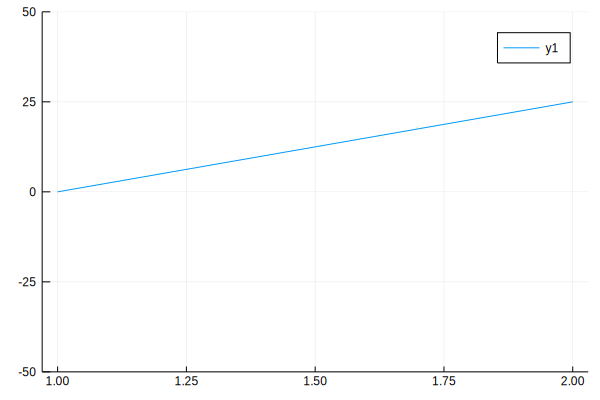

In [53]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (-50,50))

In [10]:
θ = convert(Matrix, CSV.read("0.473_final.csv"))


30420×6 Array{Float64,2}:
  -4.05719   0.0         -12.7585    0.0           -5.40401   0.0        
 -14.1363    0.0         -13.7421    0.0           -8.10245   0.0        
 -10.3976    0.0         -10.766     0.0341359    -10.7977    0.0        
  -2.55388   0.0         -18.6888    0.0183138     -9.52957   0.0        
  -1.0819    0.0157158    -0.916452  0.00300404    -0.331465  0.0        
   0.855674  0.00673533    5.65503   0.0            0.654088  0.0        
   1.16456   0.0          11.4057    0.00685856     0.607544  0.0        
   1.58071   0.0247135     3.96063   0.000762062    0.405348  0.000318762
   4.4065    0.0255353     0.472534  0.0            0.411339  0.0040335  
   5.23843   0.00871109    0.426326  0.0            0.405973  0.000776428
   5.00093   0.018768      0.61746   0.0            0.590034  0.0        
   4.63067   0.0385562     0.547618  0.0            0.593071  0.0        
   6.30795   0.00124996    0.443488  0.0            0.594687  0.0        
   ⋮        

In [17]:
#θ = convert(Matrix, thetaframe)

In [57]:
thetaframe = DataFrame(θ)
CSV.write("0.473_final.csv", thetaframe)

"0.473_final.csv"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5